In [1]:
import datetime
import gc
import joblib
import json
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import optuna
import os
import scipy.stats
import seaborn as sns
import sys
sys.path.append("../")
import time
import warnings
warnings.simplefilter("ignore")
from imblearn.over_sampling import SMOTE
from itertools import repeat
from lightgbm import LGBMClassifier, log_evaluation
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, fbeta_score, make_scorer
from tqdm import tqdm

In [2]:
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
from cycler import cycler
from IPython.display import display
from colorama import Fore, Back, Style
plt.rcParams['axes.facecolor'] = '#0057b8' # blue
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])
plt.rcParams['text.color'] = 'w'

In [3]:
from utils.common import (
    sigmoid, pad_column_name
)
from utils.constants import (
    RAW_DATA_PATH, PROCESSED_DATA_PATH
)
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.eda_helpers import (
    plot_missing_proportion_barchart, 
    get_cols
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, NON_FEATURE_COLUMNS,
    MEAN_FEATURES, MIN_FEATURES, MAX_FEATURES, LAST_FEATURES, FIRST_FEATURES,
    RANGE_FEATURES, VELOCITY_FEATURES, SPEED_FEATURES
)

In [4]:
RAW_DATA_PATH = "../raw_data"
PROCESSED_DATA_PATH = "../processed_data"
SUBMISSION_DATA_PATH = "../submissions"
EVALUATION_DATA_PATH = "../evaluation_data"
MODELS_PATH = "../models"
EXP_PATH = "../experiments"
DROP_FEATURES_PATH = "../dropped_features"

In [5]:
%load_ext autoreload
%autoreload

### Read Data

In [6]:
%%time
train_agg = read_file(f"{PROCESSED_DATA_PATH}/train_agg_complete2.pkl")

Shape of data: (458913, 4301)
CPU times: user 4.23 s, sys: 17 s, total: 21.2 s
Wall time: 41.4 s


In [123]:
labels = read_file(f"{RAW_DATA_PATH}/train_labels.csv")

Shape of data: (458913, 2)


In [7]:
# less_imp_features = [
#      'B_30', 'B_31', 'B_32', 'B_39', 'B_41', 'B_42', 
#      'D_103', 'D_109', 'D_111', 'D_116', 'D_127', 'D_135', 'D_137', 'D_139', 'D_143', 
#      'D_73', 'D_81', 'D_83', 'D_84', 'D_86', 'D_87', 'D_88', 'D_89', 'D_92', 'D_93', 'D_94', 
#      'R_13', 'R_14', 'R_17', 'R_18', 'R_19', 'R_20', 'R_21', 'R_22', 'R_23', 'R_24', 'R_25', 'R_28', 'S_18', 'S_20'
# ]
# less_imp_agg_features = [col for col in train_agg.columns if any([c in col for c in less_imp_features])]
# train_agg = train_agg.loc[:, less_imp_agg_features]

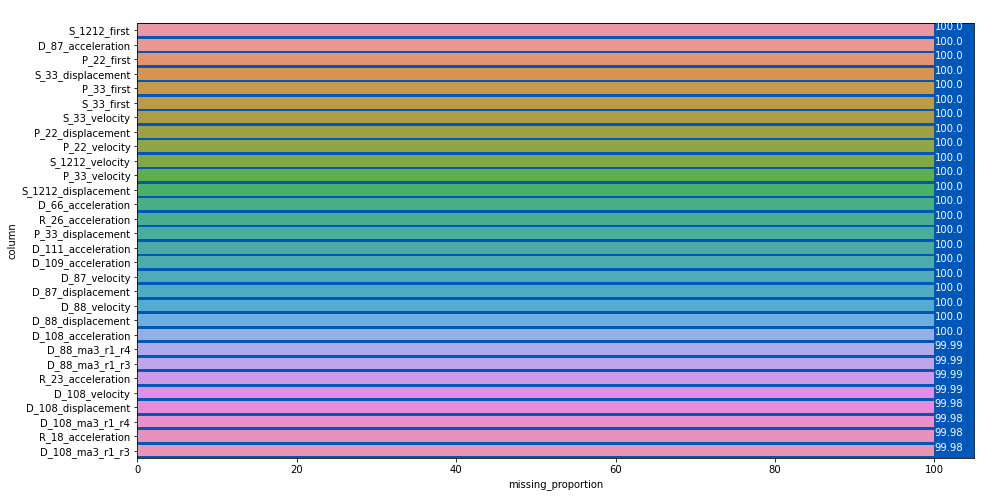

In [8]:
m = plot_missing_proportion_barchart(train_agg)

In [9]:
# less_imp_agg_features = m.loc[m["missing_proportion"] < 50]["column"].tolist()
# train_agg = train_agg.loc[:, less_imp_agg_features]

In [10]:
train_agg.shape

(458913, 4301)

### Pre-train Feature Reduction

In [94]:
lgbm_feature_imp1 = read_file(f"{EXP_PATH}/feature_imp_summary1.csv")
# lgbm_feature_imp_summary = lgbm_feature_imp.describe().T
# lgbm_feature_imp_summary = lgbm_feature_imp_summary.sort_values(by="mean", ascending=False)

Shape of data: (188, 22)


In [95]:
lgbm_feature_imp2 = read_file(f"{EXP_PATH}/feature_imp_summary2.csv")

Shape of data: (148, 22)


In [112]:
drop_features = []

In [113]:
# lgbm_feature_imp1.describe()

In [114]:
THRESHOLD1 = 20
for type_ in tqdm(lgbm_feature_imp1.columns[1:]):
    drop_features.extend(
        (
            lgbm_feature_imp1.loc[lgbm_feature_imp1[type_] <= THRESHOLD1]["base_feature"] + "_" + type_
        ).tolist()
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 1727.13it/s]


In [115]:
len(drop_features)

1941

In [116]:
# lgbm_feature_imp2.describe()

In [117]:
THRESHOLD2 = 15
for type_ in tqdm(lgbm_feature_imp2.columns[1:]):
    drop_features.extend(
        (
            lgbm_feature_imp2.loc[lgbm_feature_imp2[type_] <= THRESHOLD2]["base_feature"] + "_" + type_
        ).tolist()
    )

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 1900.29it/s]


In [118]:
drop_features = list(set(drop_features))

In [119]:
len(drop_features)

1942

In [120]:
%%time
# train_agg = train_agg.loc[:, all_features + ["target"]]

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 11.2 µs


In [124]:
target = labels["target"].values

In [125]:
%%time
train_agg = train_agg.drop(columns=NON_FEATURE_COLUMNS + ["target"], errors="ignore")

CPU times: user 674 ms, sys: 4.62 s, total: 5.29 s
Wall time: 11.6 s


In [126]:
%%time
# train_agg = train_agg.loc[:, all_features]
train_agg = train_agg.drop(columns=drop_features, errors="ignore")

CPU times: user 293 ms, sys: 2.79 s, total: 3.09 s
Wall time: 11.1 s


In [127]:
cat_columns = train_agg.select_dtypes("category").columns.to_list()

In [128]:
train_agg.shape, target.shape

((458913, 2357), (458913,))

### Oversampling / Undersampling (SMOTE)

In [ ]:
# sm = SMOTE(random_state=923)
# X_res, y_res = sm.fit_resample(train_agg, target)
# X_res.shape, y_res.shape

In [ ]:
# train_missing_prop_df = plot_missing_proportion_barchart(train, top_n=50)

In [ ]:
# train_missing_prop_df = plot_missing_proportion_barchart(train, top_n=40)

In [ ]:
# train_analysis = single_col_target_check(train, "R_13", q=10)

In [ ]:
# train_agg_analysis = single_col_target_check(train_agg, "S_6_last", q=10)

In [ ]:
# train_agg_analysis.head()

In [ ]:
# selected_features = pd.read_csv("top_features.csv")
# selected_features = selected_features["feature"].tolist()

In [ ]:
# train_agg = train_agg.loc[:, selected_features]

In [ ]:
# missing_count_df = plot_missing_proportion_barchart(train_agg)

In [ ]:
# high_missing_columns = missing_count_df.loc[missing_count_df["missing_proportion"] > 75, "column"].tolist()

In [ ]:
# print("Pre feature drop", train.shape)
# train_agg = train_agg.loc[:, set(feature_list).intersection(set(train_agg.columns))]
# train_agg = train_agg.drop(columns=high_missing_columns, errors="ignore")
# print("Post feature drop", train.shape)

### Train Single LGBM

In [83]:
kf = StratifiedKFold(n_splits=5)

In [84]:
params = {
    'metrics': "custom",
    'first_metric_only': True, 
    'random_state': 1,
    'reg_alpha': 1, #0.0125, 
    'reg_lambda': 60, 
    'learning_rate': 0.1, 
    'n_estimators': 2000, 
    'colsample_bytree': 0.5, 
    'subsample': 0.7, 
    'subsample_freq': 5, 
    'min_child_samples': 2400, 
    'scale_pos_weight': 1.9, 
    'max_bins': 10, 
    'num_leaves': 50,
    'verbose': -1
}

In [85]:
n_est_list = repeat(2000)

In [87]:
# train_score_list, val_score_list = [], []
# for fold, (idx_tr, idx_va) in zip(range(1, 5+1), kf.split(train_agg, target)):
#     fold = str(fold)
#     X_train, y_train = train_agg.iloc[idx_tr], target[idx_tr]
#     train_data = lgb.Dataset(
#         X_train,
#         y_train
#     )
#     X_val, y_val = train_agg.iloc[idx_va], target[idx_va], 
#     valid_data = lgb.Dataset(
#         X_val,
#         y_val,
#         reference=train_data
#     )
#     print("Start Training")
#     with warnings.catch_warnings():
#         warnings.filterwarnings('ignore', category=UserWarning)
#         model = lgb.train(
#             params=params,
#             train_set=train_data, 
#             valid_sets=valid_data, 
#             feval=lgb_amex_metric, 
#             early_stopping_rounds=5,
#             categorical_feature=cat_columns,
#             callbacks=[
#                 log_evaluation(5),
#             ]
#         )
#     y_train_pred = model.predict(X_train, raw_score=True)
#     train_score, train_g, train_t4 = amex_metric(y_train, y_train_pred)
#     X_train, y_train = None, None
#     y_val_pred = model.predict(X_val, raw_score=True)
#     val_score, val_g, val_t4 = amex_metric(y_val, y_val_pred)
#     X_val, y_val = None, None
#     train_score_list.append(train_score)
#     val_score_list.append(val_score)
#     if val_score > best_scores_json["validation"][fold]:
#         print("Good")
#         # best_scores_json["train"][fold] = train_score
#         # best_scores_json["validation"][fold] = val_score
#         # with open(f'{CURRENT_EXP_PATH}/best_scores.json', "w") as outfile:
#         #     json.dump(best_scores_json, outfile)
#         # joblib.dump(model, f'{CURRENT_EXP_PATH}/models/model{fold}.pkl')
#     elif np.mean(train_score_list) >= np.mean(list(best_scores_json["train"].values())) + 0.05:
#         print(f"Train score too high (overfitting), start a new trial")
#     print(f"{Fore.BLUE}{Style.BRIGHT}Fold {fold} | Train Score = {train_score:.5f} ({train_g:.4f}, {train_t4:.4f})")
#     print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | Val Score = {val_score:.5f} ({val_g:.4f}, {val_t4:.4f}){Style.RESET_ALL}")

In [ ]:
np.mean(val_score_list)

In [ ]:
# imp_df = plot_feature_importance(model.feature_name_, model.feature_importances_, figsize=(16, 50), ascending=True, limit=300)

In [ ]:
imp_df.loc[imp_df["feature"] == "dummy"]

In [ ]:
zero_imp_features = sorted(imp_df.loc[imp_df["feature_importance"] == 0]["feature"].values.tolist())

In [ ]:
pd.Series(zero_imp_features, name="feature").to_csv(f"{DROP_FEATURES_PATH}/noob_features.csv", index=False)

In [ ]:
# train["target"] = target
# train.to_pickle(f"{EXP_PATH}/lgbm_gbdt_exp2/train_val.pkl")
# joblib.dump(train_score_list, f'{EXP_PATH}/lgbm_gbdt_exp2/5_fold_train_scores.pkl')
# joblib.dump(val_score_list, f'{EXP_PATH}/lgbm_gbdt_exp2/5_fold_val_scores.pkl')
# joblib.dump(val_idx_list, f'{EXP_PATH}/lgbm_gbdt_exp2/5_fold_val_indices.pkl')

### Tune LGBM using Optuna (Single)

In [ ]:
def objective(trial):
    params = {
        "objective": "binary",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 1,
        "reg_alpha": trial.suggest_float("reg_alpha", 0.001, 0.1, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 15, 30, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 0.015, 0.03, log=True),
        "n_estimators": trial.suggest_categorical("n_estimators", [1500, 1600, 1700, 1800, 1900, 2000]),
        "colsample_bytree": trial.suggest_categorical("colsample_bytree", np.arange(0.15, 0.4, 0.01)),
        "subsample": trial.suggest_categorical("subsample", np.arange(0.6, 0.8, 0.02)),
        "subsample_freq": trial.suggest_categorical("subsample_freq", [1, 2]),
        "min_child_samples": trial.suggest_categorical("min_child_samples", [2000, 2250, 2500]),
        "min_child_weight": trial.suggest_float("min_child_weight", 0.01, 450, log=True),
        "scale_pos_weight": trial.suggest_categorical("scale_pos_weight", np.arange(1.25, 2.5, 0.05)),
        "max_bins": trial.suggest_categorical("max_bins", np.arange(400, 550, 25)),
        "num_leaves": trial.suggest_categorical("num_leaves", np.arange(70, 180, 10)),
    }
    print(params)
    X_train, X_val, y_train, y_val = train_test_split(train_agg, target, test_size=0.2)
    model = LGBMClassifier(**params)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)], 
            eval_metric=[lgb_amex_metric],
            callbacks=[log_evaluation(200)]
        )
    y_train_pred = model.predict_proba(X_train, raw_score=True)
    train_score = amex_metric(y_train, y_train_pred)
    y_val_pred = model.predict_proba(X_val, raw_score=True)
    val_score = amex_metric(y_val, y_val_pred)
    print(f"Fold {fold} | Train Score = {train_score:.5f}")
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | Val   Score = {val_score:.5f}{Style.RESET_ALL}")
    return val_score

In [ ]:
study = optuna.create_study(direction="maximize")

In [ ]:
study.optimize(objective, n_trials=5)

### Tune LGBM using Optuna (KFold)

In [131]:
CURRENT_EXP_PATH = f"{EXP_PATH}/lgbm_gbdt_exp"
CURRENT_EXP_PATH

'../experiments/lgbm_gbdt_exp'

In [141]:
with open(f"{CURRENT_EXP_PATH}/best_scores.json", "r+") as outfile:
    best_scores_json = json.load(outfile)
np.mean(list(best_scores_json["validation"].values()))

0.796893205929831

In [133]:
# kf = StratifiedKFold(n_splits=5)
# for idx_tr, idx_va in kf.split(train_agg, target):
#     print(idx_va)

In [138]:
def objective(trial):
    kf = StratifiedKFold(n_splits=5)
    params = {
        "objective": "binary",
        "metrics": "custom",
        "first_metric_only": True, 
        "boost_from_average": False,
        "verbosity": -1,
        "boosting_type": "gbdt",
        "random_state": 1,
        "learning_rate": 0.02,
        "n_estimators": 7500,
        "max_bins": 255,
        "subsample_freq": 2,
        "min_child_samples": 1500,
        "reg_alpha": trial.suggest_float("reg_alpha", 0.003, 0.3, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 20, 60, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.18, 0.28),
        "subsample": trial.suggest_float("subsample", 0.65, 0.75),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.2, 3),
        "num_leaves": trial.suggest_int("num_leaves", 60, 150)
    }
    print(
        "alpha", round(params["reg_alpha"], 4), 
        "lambda", round(params["reg_lambda"], 4),
        "colsample_bytree", round(params["colsample_bytree"], 3),
        "subsample", round(params["subsample"], 3), 
        "scale_pos_weight", round(params["scale_pos_weight"], 3), 
        "num_leaves", round(params["num_leaves"], 0)
    )
    train_score_list, val_score_list = [], []
    for fold, (idx_tr, idx_va) in zip(range(1, 5+1), kf.split(train_agg, target)):
        fold = str(fold)
        X_train, y_train = train_agg.iloc[idx_tr], target[idx_tr]
        train_data = lgb.Dataset(
            X_train,
            y_train
        )
        X_val, y_val = train_agg.iloc[idx_va], target[idx_va], 
        valid_data = lgb.Dataset(
            X_val,
            y_val,
            reference=train_data
        )
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', category=UserWarning)
            model = lgb.train(
                params=params,
                train_set=train_data, 
                valid_sets=[valid_data, train_data], 
                feval=lgb_amex_metric, 
                early_stopping_rounds=300,
                categorical_feature=cat_columns,
                callbacks=[
                    log_evaluation(100),
                ]
            )
        y_train_pred = model.predict(X_train, raw_score=True)
        train_score, train_g, train_t4 = amex_metric(y_train, y_train_pred)
        train_data, X_train, y_train = None, None, None
        y_val_pred = model.predict(X_val, raw_score=True)
        val_score, val_g, val_t4 = amex_metric(y_val, y_val_pred)
        valid_data, X_val, y_val = None, None, None
        train_score_list.append(train_score)
        val_score_list.append(val_score)
        if val_score > best_scores_json["validation"][fold]:
            best_scores_json["train"][fold] = train_score
            best_scores_json["validation"][fold] = val_score
            with open(f'{CURRENT_EXP_PATH}/best_scores.json', "w") as outfile:
                json.dump(best_scores_json, outfile)
            joblib.dump(model, f'{CURRENT_EXP_PATH}/models/model{fold}.pkl')
        elif np.mean(train_score_list) >= np.mean(list(best_scores_json["train"].values())) + 0.05:
            print(f"Train score too high (overfitting), start a new trial")
            return np.mean(val_score_list)
        print(f"{Fore.BLUE}{Style.BRIGHT}Fold {fold} | Train Score = {train_score:.5f} ({train_g:.4f}, {train_t4:.4f})")
        print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | Val Score = {val_score:.5f} ({val_g:.4f}, {val_t4:.4f}){Style.RESET_ALL}")
        print(f"Clear cache {gc.collect()}")
        
    return np.mean(val_score_list)

In [139]:
study = optuna.create_study(direction="maximize")

[I 2022-07-19 03:45:14,905] A new study created in memory with name: no-name-e97120eb-2c04-4045-9918-e2841da714c6


In [140]:
study.optimize(objective, n_trials=25)

alpha 0.0084 lambda 33.81 colsample_bytree 0.201 subsample 0.657 scale_pos_weight 2.873 num_leaves 103
[100]	training's amex: 0.763646	valid_0's amex: 0.756568
[200]	training's amex: 0.784568	valid_0's amex: 0.773399
[300]	training's amex: 0.800178	valid_0's amex: 0.781938
[400]	training's amex: 0.811477	valid_0's amex: 0.786085
[500]	training's amex: 0.820774	valid_0's amex: 0.789347
[600]	training's amex: 0.828921	valid_0's amex: 0.791187
[700]	training's amex: 0.837378	valid_0's amex: 0.791625
[800]	training's amex: 0.845778	valid_0's amex: 0.792401
[900]	training's amex: 0.853522	valid_0's amex: 0.793706
[1000]	training's amex: 0.861455	valid_0's amex: 0.794078
[1100]	training's amex: 0.869188	valid_0's amex: 0.793093
[1200]	training's amex: 0.877011	valid_0's amex: 0.793257
Fold 1 | Train Score = 0.86135 (0.9575, 0.7652)
Fold 1 | Val Score = 0.79416 (0.9225, 0.6658)
Clear cache 14
[100]	training's amex: 0.763928	valid_0's amex: 0.755931
[200]	training's amex: 0.784839	valid_0's am

[I 2022-07-19 04:35:53,763] Trial 0 finished with value: 0.7951455942696569 and parameters: {'reg_alpha': 0.008438197395346564, 'reg_lambda': 33.81003038010671, 'colsample_bytree': 0.2005387198777498, 'subsample': 0.656594014444382, 'scale_pos_weight': 2.8732393755754035, 'num_leaves': 103}. Best is trial 0 with value: 0.7951455942696569.


Fold 5 | Train Score = 0.85943 (0.9565, 0.7624)
Fold 5 | Val Score = 0.79694 (0.9250, 0.6689)
Clear cache 12
alpha 0.0435 lambda 34.433 colsample_bytree 0.238 subsample 0.68 scale_pos_weight 2.556 num_leaves 81
[100]	training's amex: 0.765236	valid_0's amex: 0.757758
[200]	training's amex: 0.785146	valid_0's amex: 0.774819
[300]	training's amex: 0.799837	valid_0's amex: 0.782946
[400]	training's amex: 0.81021	valid_0's amex: 0.785421
[500]	training's amex: 0.818674	valid_0's amex: 0.788819
[600]	training's amex: 0.826624	valid_0's amex: 0.790243
[700]	training's amex: 0.83365	valid_0's amex: 0.791619
[800]	training's amex: 0.841026	valid_0's amex: 0.792072
[900]	training's amex: 0.847707	valid_0's amex: 0.792868
[1000]	training's amex: 0.854712	valid_0's amex: 0.793073
[1100]	training's amex: 0.861511	valid_0's amex: 0.794216
[1200]	training's amex: 0.868024	valid_0's amex: 0.793701
[1300]	training's amex: 0.87466	valid_0's amex: 0.794104
Fold 1 | Train Score = 0.86298 (0.9574, 0.7685)

[I 2022-07-19 05:31:10,964] Trial 1 finished with value: 0.7952346796323262 and parameters: {'reg_alpha': 0.04346041875256112, 'reg_lambda': 34.43299589257389, 'colsample_bytree': 0.23754439125847782, 'subsample': 0.6798664442904587, 'scale_pos_weight': 2.555524115364568, 'num_leaves': 81}. Best is trial 1 with value: 0.7952346796323262.


Fold 5 | Train Score = 0.88120 (0.9644, 0.7980)
Fold 5 | Val Score = 0.79691 (0.9254, 0.6684)
Clear cache 16
alpha 0.0676 lambda 33.3475 colsample_bytree 0.242 subsample 0.697 scale_pos_weight 2.776 num_leaves 90
[100]	training's amex: 0.7647	valid_0's amex: 0.757181
[200]	training's amex: 0.785978	valid_0's amex: 0.774264
[300]	training's amex: 0.800713	valid_0's amex: 0.781786
[400]	training's amex: 0.811421	valid_0's amex: 0.786075
[500]	training's amex: 0.819968	valid_0's amex: 0.790104
[600]	training's amex: 0.828192	valid_0's amex: 0.792007
[700]	training's amex: 0.836173	valid_0's amex: 0.793499
[800]	training's amex: 0.844191	valid_0's amex: 0.792752
[900]	training's amex: 0.851318	valid_0's amex: 0.79316
[1000]	training's amex: 0.85866	valid_0's amex: 0.793952
[1100]	training's amex: 0.86581	valid_0's amex: 0.794367
[1200]	training's amex: 0.872886	valid_0's amex: 0.794518
[1300]	training's amex: 0.880489	valid_0's amex: 0.794484
[1400]	training's amex: 0.887209	valid_0's amex

[I 2022-07-19 06:16:50,183] Trial 2 finished with value: 0.7946309758752326 and parameters: {'reg_alpha': 0.06759806361707751, 'reg_lambda': 33.34752602551409, 'colsample_bytree': 0.2417314183670896, 'subsample': 0.6972839304966406, 'scale_pos_weight': 2.7761464008212635, 'num_leaves': 90}. Best is trial 1 with value: 0.7952346796323262.


Fold 5 | Train Score = 0.86781 (0.9598, 0.7759)
Fold 5 | Val Score = 0.79669 (0.9252, 0.6682)
Clear cache 256
alpha 0.1563 lambda 20.7572 colsample_bytree 0.229 subsample 0.747 scale_pos_weight 1.462 num_leaves 131
[100]	training's amex: 0.769923	valid_0's amex: 0.761306
[200]	training's amex: 0.789808	valid_0's amex: 0.776848
[300]	training's amex: 0.805953	valid_0's amex: 0.783504
[400]	training's amex: 0.820507	valid_0's amex: 0.786621
[500]	training's amex: 0.832887	valid_0's amex: 0.790158
[600]	training's amex: 0.843815	valid_0's amex: 0.79154
[700]	training's amex: 0.85534	valid_0's amex: 0.792754
[800]	training's amex: 0.866304	valid_0's amex: 0.793017
[900]	training's amex: 0.876971	valid_0's amex: 0.794241
[1000]	training's amex: 0.887379	valid_0's amex: 0.794635
[1100]	training's amex: 0.897929	valid_0's amex: 0.794936
[1200]	training's amex: 0.908165	valid_0's amex: 0.794773
[1300]	training's amex: 0.917625	valid_0's amex: 0.795166
[1400]	training's amex: 0.926429	valid_0's

[I 2022-07-19 07:10:05,245] Trial 3 finished with value: 0.7960066762288064 and parameters: {'reg_alpha': 0.15629259686394384, 'reg_lambda': 20.757211453956817, 'colsample_bytree': 0.22939108134538722, 'subsample': 0.7465315129708244, 'scale_pos_weight': 1.4621211311653781, 'num_leaves': 131}. Best is trial 3 with value: 0.7960066762288064.


Fold 5 | Train Score = 0.90717 (0.9712, 0.8432)
Fold 5 | Val Score = 0.79796 (0.9253, 0.6707)
Clear cache 62
alpha 0.0077 lambda 38.6188 colsample_bytree 0.265 subsample 0.733 scale_pos_weight 1.21 num_leaves 133
[100]	training's amex: 0.768051	valid_0's amex: 0.759718
[200]	training's amex: 0.788369	valid_0's amex: 0.77562
[300]	training's amex: 0.803801	valid_0's amex: 0.783037
[400]	training's amex: 0.817317	valid_0's amex: 0.788022
[500]	training's amex: 0.829405	valid_0's amex: 0.789426
[600]	training's amex: 0.839641	valid_0's amex: 0.791006
[700]	training's amex: 0.850466	valid_0's amex: 0.792044
[800]	training's amex: 0.861114	valid_0's amex: 0.791944
[900]	training's amex: 0.871811	valid_0's amex: 0.792352
[1000]	training's amex: 0.881642	valid_0's amex: 0.791831
[1100]	training's amex: 0.891627	valid_0's amex: 0.793104
[1200]	training's amex: 0.901134	valid_0's amex: 0.79322
[1300]	training's amex: 0.909777	valid_0's amex: 0.793458
[1400]	training's amex: 0.918141	valid_0's a

[I 2022-07-19 08:04:05,212] Trial 4 finished with value: 0.7950116711636616 and parameters: {'reg_alpha': 0.007667806511356941, 'reg_lambda': 38.618814283785134, 'colsample_bytree': 0.26501942335573764, 'subsample': 0.7328816385306529, 'scale_pos_weight': 1.209573520563927, 'num_leaves': 133}. Best is trial 3 with value: 0.7960066762288064.


Fold 5 | Train Score = 0.89803 (0.9669, 0.8291)
Fold 5 | Val Score = 0.79715 (0.9250, 0.6693)
Clear cache 14
alpha 0.0202 lambda 37.6279 colsample_bytree 0.238 subsample 0.705 scale_pos_weight 1.927 num_leaves 92
[100]	training's amex: 0.766364	valid_0's amex: 0.758012
[200]	training's amex: 0.78609	valid_0's amex: 0.774355
[300]	training's amex: 0.801498	valid_0's amex: 0.781499
[400]	training's amex: 0.812648	valid_0's amex: 0.786518
[500]	training's amex: 0.822594	valid_0's amex: 0.789277
[600]	training's amex: 0.831837	valid_0's amex: 0.791599
[700]	training's amex: 0.839707	valid_0's amex: 0.792059
[800]	training's amex: 0.848046	valid_0's amex: 0.79188
[900]	training's amex: 0.855968	valid_0's amex: 0.792551
[1000]	training's amex: 0.863972	valid_0's amex: 0.79351
[1100]	training's amex: 0.871581	valid_0's amex: 0.794815
[1200]	training's amex: 0.878918	valid_0's amex: 0.79426
[1300]	training's amex: 0.886848	valid_0's amex: 0.79446
[1400]	training's amex: 0.893711	valid_0's amex

[I 2022-07-19 08:54:13,306] Trial 5 finished with value: 0.7951595019458934 and parameters: {'reg_alpha': 0.020237214552749294, 'reg_lambda': 37.627938162049155, 'colsample_bytree': 0.2377915676643187, 'subsample': 0.705393674925985, 'scale_pos_weight': 1.9270400268521293, 'num_leaves': 92}. Best is trial 3 with value: 0.7960066762288064.


Fold 5 | Train Score = 0.87772 (0.9614, 0.7940)
Fold 5 | Val Score = 0.79714 (0.9252, 0.6691)
Clear cache 12
alpha 0.0288 lambda 43.6733 colsample_bytree 0.201 subsample 0.662 scale_pos_weight 2.957 num_leaves 141
[100]	training's amex: 0.76266	valid_0's amex: 0.754995
[200]	training's amex: 0.783753	valid_0's amex: 0.773039
[300]	training's amex: 0.799229	valid_0's amex: 0.782299
[400]	training's amex: 0.810913	valid_0's amex: 0.785328
[500]	training's amex: 0.821227	valid_0's amex: 0.788234
[600]	training's amex: 0.8302	valid_0's amex: 0.791066
[700]	training's amex: 0.838525	valid_0's amex: 0.79168
[800]	training's amex: 0.847192	valid_0's amex: 0.792639
[900]	training's amex: 0.85557	valid_0's amex: 0.793099
[1000]	training's amex: 0.86378	valid_0's amex: 0.793512
[1100]	training's amex: 0.87195	valid_0's amex: 0.793544
[1200]	training's amex: 0.879814	valid_0's amex: 0.793906
[1300]	training's amex: 0.887576	valid_0's amex: 0.793992
[1400]	training's amex: 0.895271	valid_0's amex:

[I 2022-07-19 09:51:54,694] Trial 6 finished with value: 0.7947643542219426 and parameters: {'reg_alpha': 0.02884839552832661, 'reg_lambda': 43.67334523997354, 'colsample_bytree': 0.2011837470269477, 'subsample': 0.6618531607167095, 'scale_pos_weight': 2.956971046250432, 'num_leaves': 141}. Best is trial 3 with value: 0.7960066762288064.


Fold 5 | Train Score = 0.90604 (0.9733, 0.8388)
Fold 5 | Val Score = 0.79749 (0.9253, 0.6697)
Clear cache 384
alpha 0.039 lambda 34.4518 colsample_bytree 0.266 subsample 0.731 scale_pos_weight 2.395 num_leaves 137
[100]	training's amex: 0.76609	valid_0's amex: 0.757826
[200]	training's amex: 0.787024	valid_0's amex: 0.775309
[300]	training's amex: 0.803561	valid_0's amex: 0.782751
[400]	training's amex: 0.817021	valid_0's amex: 0.786069
[500]	training's amex: 0.827685	valid_0's amex: 0.788093
[600]	training's amex: 0.838815	valid_0's amex: 0.790151
[700]	training's amex: 0.849231	valid_0's amex: 0.791377
[800]	training's amex: 0.859071	valid_0's amex: 0.792359
[900]	training's amex: 0.869181	valid_0's amex: 0.793115
[1000]	training's amex: 0.879059	valid_0's amex: 0.793624
[1100]	training's amex: 0.888528	valid_0's amex: 0.79412
[1200]	training's amex: 0.898214	valid_0's amex: 0.794929
[1300]	training's amex: 0.907088	valid_0's amex: 0.794532
[1400]	training's amex: 0.915952	valid_0's 

[I 2022-07-19 10:42:12,032] Trial 7 finished with value: 0.7947940883075126 and parameters: {'reg_alpha': 0.03899655499909763, 'reg_lambda': 34.45176165941243, 'colsample_bytree': 0.2662200580513782, 'subsample': 0.7311620865759083, 'scale_pos_weight': 2.3954161377161665, 'num_leaves': 137}. Best is trial 3 with value: 0.7960066762288064.


Fold 5 | Train Score = 0.87820 (0.9632, 0.7932)
Fold 5 | Val Score = 0.79647 (0.9250, 0.6680)
Clear cache 8
alpha 0.0187 lambda 21.7325 colsample_bytree 0.203 subsample 0.725 scale_pos_weight 1.328 num_leaves 115
[100]	training's amex: 0.769609	valid_0's amex: 0.760866
[200]	training's amex: 0.788826	valid_0's amex: 0.776239
[300]	training's amex: 0.804495	valid_0's amex: 0.782518
[400]	training's amex: 0.818085	valid_0's amex: 0.786478
[500]	training's amex: 0.829824	valid_0's amex: 0.78867
[600]	training's amex: 0.840945	valid_0's amex: 0.790338
[700]	training's amex: 0.851398	valid_0's amex: 0.792219
[800]	training's amex: 0.861445	valid_0's amex: 0.793016
[900]	training's amex: 0.871613	valid_0's amex: 0.792596
[1000]	training's amex: 0.881459	valid_0's amex: 0.794012
[1100]	training's amex: 0.890521	valid_0's amex: 0.794578
[1200]	training's amex: 0.900141	valid_0's amex: 0.795291
[1300]	training's amex: 0.908632	valid_0's amex: 0.795026
[1400]	training's amex: 0.917244	valid_0's 

[I 2022-07-19 11:44:48,293] Trial 8 finished with value: 0.7957737020598233 and parameters: {'reg_alpha': 0.018710186285392744, 'reg_lambda': 21.732474057796768, 'colsample_bytree': 0.20349933321127467, 'subsample': 0.7252397773114443, 'scale_pos_weight': 1.3283783657596826, 'num_leaves': 115}. Best is trial 3 with value: 0.7960066762288064.


Fold 5 | Train Score = 0.86596 (0.9557, 0.7762)
Fold 5 | Val Score = 0.79606 (0.9247, 0.6674)
Clear cache 10
alpha 0.1223 lambda 25.6121 colsample_bytree 0.229 subsample 0.743 scale_pos_weight 2.75 num_leaves 74
[100]	training's amex: 0.766708	valid_0's amex: 0.758419
[200]	training's amex: 0.786526	valid_0's amex: 0.774965
[300]	training's amex: 0.800421	valid_0's amex: 0.782221
[400]	training's amex: 0.810074	valid_0's amex: 0.787016
[500]	training's amex: 0.818034	valid_0's amex: 0.789612
[600]	training's amex: 0.824777	valid_0's amex: 0.790396
[700]	training's amex: 0.831722	valid_0's amex: 0.791669
[800]	training's amex: 0.838386	valid_0's amex: 0.79181
[900]	training's amex: 0.844809	valid_0's amex: 0.79239
[1000]	training's amex: 0.850847	valid_0's amex: 0.791939
[1100]	training's amex: 0.857081	valid_0's amex: 0.792706
[1200]	training's amex: 0.863466	valid_0's amex: 0.793234
[1300]	training's amex: 0.869483	valid_0's amex: 0.793708
[1400]	training's amex: 0.875174	valid_0's am

[I 2022-07-19 12:32:50,001] Trial 9 finished with value: 0.7945923638832074 and parameters: {'reg_alpha': 0.1223139292803324, 'reg_lambda': 25.612145098333094, 'colsample_bytree': 0.2288120758106959, 'subsample': 0.7431800570870591, 'scale_pos_weight': 2.750453553313304, 'num_leaves': 74}. Best is trial 3 with value: 0.7960066762288064.


Fold 5 | Train Score = 0.84874 (0.9520, 0.7455)
Fold 5 | Val Score = 0.79752 (0.9250, 0.6701)
Clear cache 394
alpha 0.2573 lambda 20.2832 colsample_bytree 0.182 subsample 0.749 scale_pos_weight 1.717 num_leaves 117
[100]	training's amex: 0.768598	valid_0's amex: 0.759447
[200]	training's amex: 0.789118	valid_0's amex: 0.775533
[300]	training's amex: 0.804796	valid_0's amex: 0.783393
[400]	training's amex: 0.818104	valid_0's amex: 0.78761
[500]	training's amex: 0.829794	valid_0's amex: 0.790687
[600]	training's amex: 0.839897	valid_0's amex: 0.792842
[700]	training's amex: 0.850239	valid_0's amex: 0.7938
[800]	training's amex: 0.860771	valid_0's amex: 0.794548
[900]	training's amex: 0.870699	valid_0's amex: 0.79431
[1000]	training's amex: 0.879889	valid_0's amex: 0.79484
[1100]	training's amex: 0.889404	valid_0's amex: 0.794783
[1200]	training's amex: 0.898671	valid_0's amex: 0.795334
[1300]	training's amex: 0.907326	valid_0's amex: 0.795048
[1400]	training's amex: 0.915671	valid_0's am

[I 2022-07-19 13:40:19,163] Trial 10 finished with value: 0.7958331928215655 and parameters: {'reg_alpha': 0.25725047039124915, 'reg_lambda': 20.283228912124716, 'colsample_bytree': 0.18165038677889572, 'subsample': 0.7491482069558468, 'scale_pos_weight': 1.7174007779619882, 'num_leaves': 117}. Best is trial 3 with value: 0.7960066762288064.


Fold 5 | Train Score = 0.91648 (0.9745, 0.8585)
Fold 5 | Val Score = 0.79734 (0.9255, 0.6692)
Clear cache 16
alpha 0.2934 lambda 20.3554 colsample_bytree 0.187 subsample 0.749 scale_pos_weight 1.724 num_leaves 119
[100]	training's amex: 0.76865	valid_0's amex: 0.759848
[200]	training's amex: 0.789063	valid_0's amex: 0.775354
[300]	training's amex: 0.80477	valid_0's amex: 0.784471
[400]	training's amex: 0.818117	valid_0's amex: 0.788104
[500]	training's amex: 0.830117	valid_0's amex: 0.790702
[600]	training's amex: 0.84092	valid_0's amex: 0.791847
[700]	training's amex: 0.851244	valid_0's amex: 0.793008
[800]	training's amex: 0.861558	valid_0's amex: 0.793144
[900]	training's amex: 0.871932	valid_0's amex: 0.793587
[1000]	training's amex: 0.881342	valid_0's amex: 0.793774
[1100]	training's amex: 0.890825	valid_0's amex: 0.793392
[1200]	training's amex: 0.900238	valid_0's amex: 0.794269
[1300]	training's amex: 0.908818	valid_0's amex: 0.79421
[1400]	training's amex: 0.917807	valid_0's am

[I 2022-07-19 14:46:04,543] Trial 11 finished with value: 0.7957732346906123 and parameters: {'reg_alpha': 0.29341553406478604, 'reg_lambda': 20.35543031223038, 'colsample_bytree': 0.18655505345817724, 'subsample': 0.7492377352128065, 'scale_pos_weight': 1.7244308174539795, 'num_leaves': 119}. Best is trial 3 with value: 0.7960066762288064.


Fold 5 | Train Score = 0.91745 (0.9748, 0.8601)
Fold 5 | Val Score = 0.79712 (0.9253, 0.6689)
Clear cache 16
alpha 0.2804 lambda 55.6506 colsample_bytree 0.218 subsample 0.71 scale_pos_weight 1.571 num_leaves 150
[100]	training's amex: 0.766384	valid_0's amex: 0.757516
[200]	training's amex: 0.785723	valid_0's amex: 0.774732
[300]	training's amex: 0.800469	valid_0's amex: 0.781249
[400]	training's amex: 0.813595	valid_0's amex: 0.786035
[500]	training's amex: 0.824043	valid_0's amex: 0.788669
[600]	training's amex: 0.833567	valid_0's amex: 0.790338
[700]	training's amex: 0.842585	valid_0's amex: 0.791878
[800]	training's amex: 0.852355	valid_0's amex: 0.792787
[900]	training's amex: 0.860981	valid_0's amex: 0.793522
[1000]	training's amex: 0.870381	valid_0's amex: 0.793309
[1100]	training's amex: 0.878892	valid_0's amex: 0.793634
[1200]	training's amex: 0.887553	valid_0's amex: 0.793471
[1300]	training's amex: 0.895925	valid_0's amex: 0.793895
[1400]	training's amex: 0.903341	valid_0's

[I 2022-07-19 15:41:23,877] Trial 12 finished with value: 0.7947107206501238 and parameters: {'reg_alpha': 0.28036157065462064, 'reg_lambda': 55.6505859992399, 'colsample_bytree': 0.21843483229424465, 'subsample': 0.7100233793832966, 'scale_pos_weight': 1.5712134920399206, 'num_leaves': 150}. Best is trial 3 with value: 0.7960066762288064.


Fold 5 | Train Score = 0.92654 (0.9769, 0.8761)
Fold 5 | Val Score = 0.79756 (0.9253, 0.6698)
Clear cache 270
alpha 0.1293 lambda 25.5251 colsample_bytree 0.186 subsample 0.718 scale_pos_weight 2.12 num_leaves 123
[100]	training's amex: 0.767385	valid_0's amex: 0.759087
[200]	training's amex: 0.787686	valid_0's amex: 0.775478
[300]	training's amex: 0.803565	valid_0's amex: 0.783644
[400]	training's amex: 0.8165	valid_0's amex: 0.787539
[500]	training's amex: 0.827593	valid_0's amex: 0.789284
[600]	training's amex: 0.838262	valid_0's amex: 0.791186
[700]	training's amex: 0.848036	valid_0's amex: 0.791568
[800]	training's amex: 0.857694	valid_0's amex: 0.793308
[900]	training's amex: 0.866896	valid_0's amex: 0.793468
[1000]	training's amex: 0.875811	valid_0's amex: 0.793508
[1100]	training's amex: 0.884902	valid_0's amex: 0.793616
[1200]	training's amex: 0.894021	valid_0's amex: 0.79367
[1300]	training's amex: 0.903456	valid_0's amex: 0.794353
[1400]	training's amex: 0.911754	valid_0's a

[I 2022-07-19 16:53:16,412] Trial 13 finished with value: 0.7959501164251127 and parameters: {'reg_alpha': 0.1292964332628893, 'reg_lambda': 25.52509847686367, 'colsample_bytree': 0.18607057534399804, 'subsample': 0.7183196237781784, 'scale_pos_weight': 2.1201225102010617, 'num_leaves': 123}. Best is trial 3 with value: 0.7960066762288064.


Fold 5 | Train Score = 0.88874 (0.9664, 0.8111)
Fold 5 | Val Score = 0.79617 (0.9252, 0.6672)
Clear cache 322
alpha 0.1149 lambda 25.8219 colsample_bytree 0.217 subsample 0.716 scale_pos_weight 2.136 num_leaves 131
[100]	training's amex: 0.767693	valid_0's amex: 0.759406
[200]	training's amex: 0.78718	valid_0's amex: 0.775307
[300]	training's amex: 0.803865	valid_0's amex: 0.782583
[400]	training's amex: 0.816761	valid_0's amex: 0.787325
[500]	training's amex: 0.827891	valid_0's amex: 0.790768
[600]	training's amex: 0.838526	valid_0's amex: 0.792204
[700]	training's amex: 0.8486	valid_0's amex: 0.792375
[800]	training's amex: 0.85917	valid_0's amex: 0.792966
[900]	training's amex: 0.868811	valid_0's amex: 0.792748
[1000]	training's amex: 0.878521	valid_0's amex: 0.793676
[1100]	training's amex: 0.888152	valid_0's amex: 0.793778
[1200]	training's amex: 0.897633	valid_0's amex: 0.793359
[1300]	training's amex: 0.906813	valid_0's amex: 0.794137
[1400]	training's amex: 0.915472	valid_0's a

[I 2022-07-19 17:56:59,155] Trial 14 finished with value: 0.7955684976545001 and parameters: {'reg_alpha': 0.11488985018701638, 'reg_lambda': 25.821927454020493, 'colsample_bytree': 0.21722563225523284, 'subsample': 0.7162624353434632, 'scale_pos_weight': 2.1362255897744586, 'num_leaves': 131}. Best is trial 3 with value: 0.7960066762288064.


Fold 5 | Train Score = 0.89441 (0.9684, 0.8204)
Fold 5 | Val Score = 0.79667 (0.9252, 0.6682)
Clear cache 14
alpha 0.0031 lambda 25.6501 colsample_bytree 0.279 subsample 0.691 scale_pos_weight 2.167 num_leaves 125
[100]	training's amex: 0.766891	valid_0's amex: 0.758929
[200]	training's amex: 0.787153	valid_0's amex: 0.775818
[300]	training's amex: 0.803476	valid_0's amex: 0.782511
[400]	training's amex: 0.816416	valid_0's amex: 0.786488
[500]	training's amex: 0.828123	valid_0's amex: 0.789833
[600]	training's amex: 0.838952	valid_0's amex: 0.790848
[700]	training's amex: 0.848803	valid_0's amex: 0.791754
[800]	training's amex: 0.85894	valid_0's amex: 0.79176
[900]	training's amex: 0.868638	valid_0's amex: 0.792162
[1000]	training's amex: 0.878152	valid_0's amex: 0.792369
[1100]	training's amex: 0.887437	valid_0's amex: 0.792655
[1200]	training's amex: 0.897114	valid_0's amex: 0.792944
[1300]	training's amex: 0.906602	valid_0's amex: 0.793257
[1400]	training's amex: 0.915181	valid_0's 

[I 2022-07-19 19:11:24,788] Trial 15 finished with value: 0.7946125327595374 and parameters: {'reg_alpha': 0.003080793109368129, 'reg_lambda': 25.650113474511755, 'colsample_bytree': 0.278846187108907, 'subsample': 0.6910838313893504, 'scale_pos_weight': 2.166617983745954, 'num_leaves': 125}. Best is trial 3 with value: 0.7960066762288064.


Fold 5 | Train Score = 0.85556 (0.9540, 0.7571)
Fold 5 | Val Score = 0.79567 (0.9246, 0.6667)
Clear cache 8
alpha 0.1461 lambda 28.72 colsample_bytree 0.253 subsample 0.721 scale_pos_weight 2.361 num_leaves 104
[100]	training's amex: 0.766611	valid_0's amex: 0.757828
[200]	training's amex: 0.787244	valid_0's amex: 0.775705
[300]	training's amex: 0.803149	valid_0's amex: 0.78223
[400]	training's amex: 0.815118	valid_0's amex: 0.787025
[500]	training's amex: 0.825314	valid_0's amex: 0.789478
[600]	training's amex: 0.834704	valid_0's amex: 0.791063
[700]	training's amex: 0.843452	valid_0's amex: 0.791036
[800]	training's amex: 0.852736	valid_0's amex: 0.792461
[900]	training's amex: 0.861405	valid_0's amex: 0.79353
[1000]	training's amex: 0.870315	valid_0's amex: 0.793742
[1100]	training's amex: 0.878699	valid_0's amex: 0.794072
[1200]	training's amex: 0.886911	valid_0's amex: 0.794239
[1300]	training's amex: 0.894968	valid_0's amex: 0.794501
[1400]	training's amex: 0.902979	valid_0's ame

[I 2022-07-19 20:15:19,581] Trial 16 finished with value: 0.7950486345332597 and parameters: {'reg_alpha': 0.14609681144948172, 'reg_lambda': 28.719967504177053, 'colsample_bytree': 0.25291380686728787, 'subsample': 0.7210326604443883, 'scale_pos_weight': 2.3614586022059987, 'num_leaves': 104}. Best is trial 3 with value: 0.7960066762288064.


Fold 5 | Train Score = 0.84574 (0.9499, 0.7416)
Fold 5 | Val Score = 0.79578 (0.9245, 0.6671)
Clear cache 212
alpha 0.0732 lambda 22.5788 colsample_bytree 0.216 subsample 0.737 scale_pos_weight 1.939 num_leaves 143
[100]	training's amex: 0.768824	valid_0's amex: 0.759905
[200]	training's amex: 0.788606	valid_0's amex: 0.775925
[300]	training's amex: 0.805066	valid_0's amex: 0.784366
[400]	training's amex: 0.819303	valid_0's amex: 0.787747



KeyboardInterrupt



### END

In [115]:
# del train_agg, target

In [142]:
study_df = study.trials_dataframe()

In [143]:
study_df = study_df.loc[study_df["state"] == "COMPLETE"]

In [146]:
study_df.to_csv(f"{CURRENT_EXP_PATH}/optuna_trials.csv", index=False)

In [186]:
# read_file(f'{EXP_PATH}/lgbm_gbdt_exp3/optuna_trials.csv')

In [187]:
# study_df = study_df.drop(columns="number").reset_index(drop=True).reset_index().rename(columns={"index": "number"})

In [188]:
# study_df.to_csv(f'{EXP_PATH}/lgbm_gbdt_exp3/optuna_trials.csv', index=False)

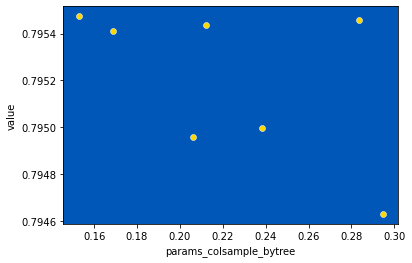

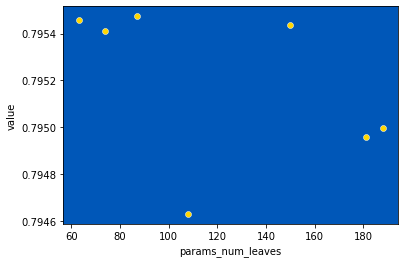

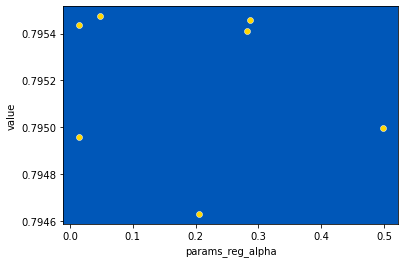

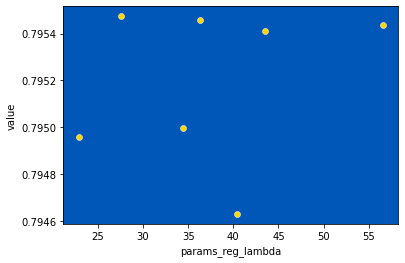

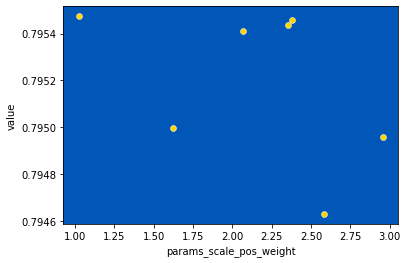

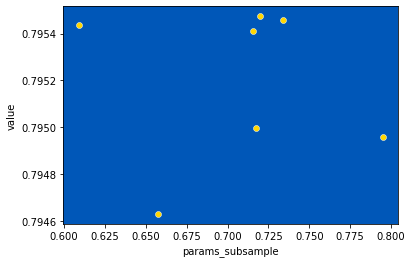

In [189]:
for col in get_cols(study_df, "params"):
    sns.scatterplot(data=study_df, x=study_df[col], y=study_df["value"])
    plt.show()

In [ ]:
# study_df = study.trials_dataframe()
# study_df = study_df.loc[study_df["state"] == "COMPLETE"].reset_index(drop=True)
# study_df.to_csv(f"{EXP_PATH}/lgbm_dart_exp/t.csv", index=False)

In [ ]:
np.mean(val_score_list)

In [ ]:
%%time
model_list, score_list, y_pred_list, held_out_index_list = [], [], [], []
model_dict = {}
X_val_dict = {}
y_val_dict = {}
y_score_dict = {}
kf = StratifiedKFold(n_splits=10)
for fold, (idx_tr, idx_va), n_est in zip(range(1, 10+1), kf.split(train, target), n_est_list):
    model_dict[fold] = joblib.load(f"{MODELS_PATH}/lgbm_models/model_{fold}.pkl")
    X_val_dict[fold] = train.iloc[idx_va][features]
    y_val_dict[fold] = target[idx_va]
    y_score_dict[fold] = model_dict[fold].predict_proba(X_val_dict[fold], raw_score=True)

In [ ]:
for i in range(1, 11):
    print(i, amex_metric_np(y_score_dict[i], y_val_dict[i]))

In [ ]:
full_train = pd.concat(list(X_val_dict.values()))
full_train.shape

In [ ]:
full_train_gt = np.concatenate(list(y_val_dict.values()))
len(full_train_gt)

In [ ]:
full_train_scores = np.concatenate(list(y_score_dict.values()))
len(full_train_scores)

In [ ]:
full_train.loc[:, "target"] = full_train_gt
full_train.loc[:, "score"] = full_train_scores

In [ ]:
# full_train.to_csv(f"{EVALUATION_DATA_PATH}/train_single_raw_score.csv", index=False)

In [ ]:
full_train

In [ ]:
%%time
model_list, score_list, y_pred_list, held_out_index_list = [], [], [], []
kf = StratifiedKFold(n_splits=10)
for fold, (idx_tr, idx_va), n_est in zip(range(1, 10+1), kf.split(train, target), n_est_list):
    X_train, X_val, y_train, y_val, model = None, None, None, None, None
    start_time = datetime.datetime.now()
    X_train = train.iloc[idx_tr][features]
    X_val = train.iloc[idx_va][features]
    y_train = target[idx_tr]
    y_val = target[idx_va]
    
    model = my_booster(n_estimators=n_est)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        model.fit(X_train, 
                  y_train,
                  eval_set=[(X_val, y_val)], 
                  eval_metric=[lgb_amex_metric],
                  callbacks=[log_evaluation(200)])
    X_train, y_train = None, None
    y_val_pred = model.predict_proba(X_val, raw_score=True)
    score = amex_metric(y_val, y_val_pred)
    n_trees = model.best_iteration_
    if n_trees is None: 
        n_trees = model.n_estimators
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | {str(datetime.datetime.now() - start_time)[-12:-7]} |"
          f" {n_trees:5} trees |"
          f"                Score = {score:.5f}{Style.RESET_ALL}")
    score_list.append(score)
    model_list.append(model)
    held_out_index_list.append(idx_va)
    # if INFERENCE:
    #     y_pred_list.append(model.predict_proba(test[features], raw_score=True))
        
    # if ONLY_FIRST_FOLD:
    #     break # we only want the first fold
    
print(f"{Fore.GREEN}{Style.BRIGHT}OOF Score:                       {np.mean(score_list):.5f}{Style.RESET_ALL}")

In [ ]:
for idx, model in enumerate(model_list):
    joblib.dump(model, f'../models/lgbm_models/model_{idx+1}.pkl')

### Test Metric

In [ ]:
y_val_df = pd.DataFrame(y_val).reset_index(drop=True)
y_val_pred_df = pd.DataFrame(y_val_pred).rename(columns={0: "prediction"})

In [ ]:
amex_metric(y_val_df, y_val_pred_df)

In [ ]:
# feature_imp_thr = imp_df.loc[imp_df["feature"] == "dummy"]["feature_importance"].values[0]
# feature_imp_thr

In [ ]:
selected_features = imp_df.loc[imp_df["feature_importance"] > 0]["feature"].tolist()
len(selected_features)

In [ ]:
y_train_pred = final_lgbm_clf.predict_proba(X_train)[:, 1]
y_val_pred = final_lgbm_clf.predict_proba(X_val)[:, 1]

In [ ]:
plot_roc_curves([y_train, y_val], 
                [y_train_pred, y_val_pred], 
                labels=["Train", "Validation"], 
                title="Train Validation ROC AUC")

In [ ]:
imp_df = plot_feature_importance(final_lgbm_clf.feature_name_, 
                                 final_lgbm_clf.feature_importances_, 
                                 title="Feature Importance",
                                 limit=50)

In [ ]:
selected_features = imp_df.loc[imp_df["feature_importance"] > 0]["feature"].tolist()
len(selected_features)

### END

### Read Data (for retrain)

In [ ]:
%%time
fail_pos_df = read_file(f"{EXP_PATH}/lgbm_gbdt_exp3/failed_positive.pkl")
fail_neg_df = read_file(f"{EXP_PATH}/lgbm_gbdt_exp3/failed_negative.pkl")
success_neg_df = read_file(f"{EXP_PATH}/lgbm_gbdt_exp3/success_negative.pkl")

In [ ]:
temp = success_neg_df.sample(fail_pos_df.shape[0] - fail_neg_df.shape[0])

In [ ]:
train_agg = pd.concat([fail_pos_df, fail_neg_df, temp], axis=0)

In [ ]:
target = train_agg["target"].values

In [ ]:
%%time
train_agg = train_agg.drop(columns=NON_FEATURE_COLUMNS, errors="ignore")

### LGBM Error Analysis

In [ ]:
X_validation = X_val_.reset_index(drop=True)

In [ ]:
top4_pct_df, gini_df = get_final_metric_df(X_validation, y_val_df, y_val_pred_df)

In [ ]:
failed_top4_pct_indices = top4_pct_df.loc[(top4_pct_df["is_cutoff"] == 1) & (top4_pct_df["target"] == 0)].index

In [ ]:
# failed_top4_pct_indices

In [ ]:
failed_top4_pct_indices

In [ ]:
success_top4 = top4_pct_df.loc[~top4_pct_df.index.isin(failed_top4_pct_indices)]
failed_top4 = top4_pct_df.loc[failed_top4_pct_indices]

In [ ]:
success_top4.shape, failed_top4.shape

In [ ]:
column = "P_2_last"

In [ ]:
top4_pct_df.groupby("target")[column].mean()

In [ ]:
success_top4[column].describe()

In [ ]:
failed_top4[column].describe()

In [ ]:
# save model
# joblib.dump(final_lgbm_clf, '../models/lgbm_version1.pkl')

In [ ]:
# load model
loaded_lgbm_model = joblib.load('../models/lgbm_version1.pkl')

### Linear Analysis

In [ ]:
array = train_data.loc[train_data["customer_ID"] == train_data["customer_ID"][540]]["P_2"].astype("float32")

In [ ]:
np.polyfit(x=range(len(array)), y=array, deg=1)

In [ ]:
def calc_grad(array):
    if len(array) >= 2:
        gradient, y_intercept = np.polyfit(x=range(len(array)), y=array.astype("float32"), deg=1)
        return gradient
    else:
        return 0

In [ ]:
def calc_intercept(array):
    if len(array) >= 2:
        gradient, y_intercept = np.polyfit(x=range(len(array)), y=array.astype("float32"), deg=1)
        return y_intercept
    else:
        return array.values[0]

In [ ]:
temp = train.groupby("customer_ID").agg(P_2_grad=("P_2", calc_grad),
                                        P_2_intercept=("P_2", calc_intercept)).reset_index()
train_agg_summary = train_agg_summary.merge(temp, on="customer_ID", how="left")

In [ ]:
temp = test.groupby("customer_ID").agg(P_2_grad=("P_2", calc_grad),
                                       P_2_intercept=("P_2", calc_intercept)).reset_index()
test_agg_summary = test_agg_summary.merge(temp, on="customer_ID", how="left")